# <center> Training dataset for rotational data augmentation </center>

## Importing libraries

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import random
import rasterio
import rasterio.plot
from osgeo import gdal
from PIL import Image
import numpy as np
from numpy import savetxt
import random
import os
import glob
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import pandas as pd
from myfunctions import geoCoord2PixelPosition, geoCoord2PixelPosition2, diagonalcorners

print('Libraries successfully imported!')

Libraries successfully imported!


In [ ]:
random.seed(10)

## Emptying image folders

In [2]:
folders = ['../data/train_rotation/*.png']
for i in range(len(folders)):
    files = glob.glob(folders[i])
    for f in files:
        os.remove(f)

## Loading the data

In [6]:
total = gpd.read_file("../layers/Groundtruth shp corrected/Kolovai-Trees-20180108.shp")
train = gpd.read_file("../layers/Groundtruth shp corrected/train_rotation.shp")

In [7]:
print(f'The total number of elements is {total.shape[0]}')
print(f'The total number of elements is {train.shape[0]}')

print('The data coordinate reference system is:', total.crs, train.crs)

The total number of elements is 11962
The total number of elements is 1552
The data coordinate reference system is: epsg:4326 epsg:4326


## Reprojecting the data into another CRS:

In [8]:
total_3857 = total.to_crs('epsg:3857')
train_3857 = train.to_crs('epsg:3857')

print(total_3857.crs, train_3857.crs) 

epsg:3857 epsg:3857


## Saving number of elements

In [9]:
total_nb = total_3857.shape[0]
train_nb = train_3857.shape[0]

## Loading and formating raster

In [10]:
raster_gdal = gdal.Open("../layers/Aerial RGB image/rgb_image.tif")
rasterArray = raster_gdal.ReadAsArray()
rasterArray_reshaped = rasterArray.transpose(1,2,0)

In [11]:
ulx, xres, xskew, uly, yskew, yres  = raster_gdal.GetGeoTransform()
lrx = ulx + (raster_gdal.RasterXSize * xres)
lry = uly + (raster_gdal.RasterYSize * yres)

In [12]:
palm_number = 1
nb_of_palms = total_3857.shape[0]

## Palm training dataset

In [13]:
train_list_palms = []
train_csv = []
palm = train_3857
window_size = 130
window_radius = int(window_size/2)

palm_indexes_end = palm.shape[0]

for palm_i in range(0, palm_indexes_end):

    saving_name = str(palm_number) + ".png"
    saving_location = "../data/train_rotation/"

    xpix, ypix = geoCoord2PixelPosition(palm.geometry.iloc[palm_i], ulx, uly, xres, yres)
    path_to_palm = saving_location + saving_name
    im = Image.fromarray(rasterArray_reshaped[(ypix-window_radius):(ypix+window_radius),(xpix-window_radius):(xpix+window_radius),:], 'RGB')
    im.save(path_to_palm)
    train_list_palms.append(str(palm_number))
    train_csv.append([palm_number,1])

    palm_number = palm_number + 1

The number of files in this directory is 1552.


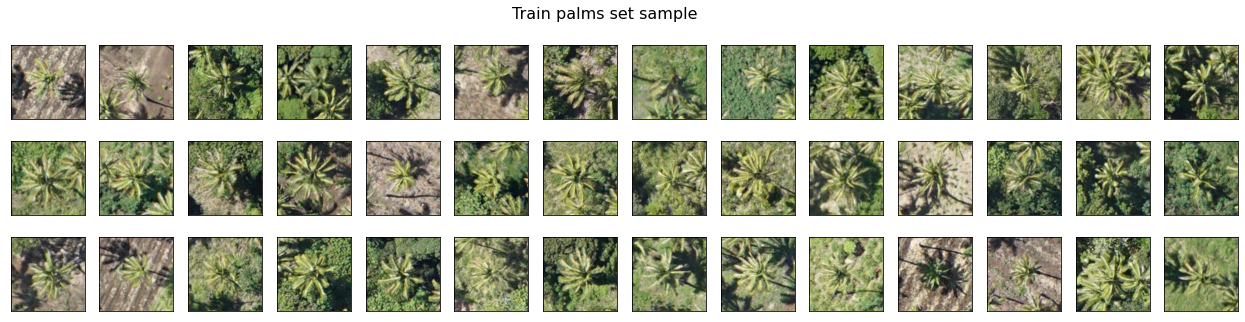

In [14]:
folder = saving_location
imgs = train_list_palms     #os.listdir(folder)
print(f'The number of files in this directory is {len(imgs)}.')

cols = 14

fig, axs = plt.subplots(3, cols, figsize = (22,5))
fig.suptitle('Train palms set sample', fontsize=16, color = 'black')
for i in range(cols):
    img_path1 = os.path.join(folder, str(random.choice(imgs)) + '.png')
    img_path2 = os.path.join(folder, str(random.choice(imgs)) + '.png')
    img_path3 = os.path.join(folder, str(random.choice(imgs)) + '.png')
    img1 = Image.open(img_path1)
    img2 = Image.open(img_path2)
    img3 = Image.open(img_path3)
    axs[0,i].imshow(img1)
    axs[1,i].imshow(img2)
    axs[2,i].imshow(img3)

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.show()

## Palm location matrix

In [15]:
palm_locations = np.zeros((raster_gdal.RasterYSize, raster_gdal.RasterXSize), dtype= np.int8)

print(palm_locations.shape)

for i in range(1, nb_of_palms):
    xpix, ypix = geoCoord2PixelPosition(total_3857.geometry.iloc[i], ulx, uly, xres, yres)
    palm_locations[ypix, xpix] = 1

## Nopalm train dataset

In [18]:
palm_number = total_nb + 1

train_list_nopalms = []
threshold = train_nb
dist_from_edges = 100
palm_location_radius = 60

xpix_min, ypix_max = geoCoord2PixelPosition2(train_3857.geometry.x.min(), train_3857.geometry.y.min(), ulx, uly, xres, yres)
xpix_max, ypix_min = geoCoord2PixelPosition2(train_3857.geometry.x.max(), train_3857.geometry.y.max(), ulx, uly, xres, yres)

i_nopalm = 1
while i_nopalm < threshold+1:
    x_random = random.randint(dist_from_edges, xpix_max - dist_from_edges)
    y_random = random.randint(dist_from_edges + ypix_min, ypix_max - dist_from_edges)    
    palm_presence = palm_locations[(y_random-palm_location_radius):(y_random+palm_location_radius),
                                   (x_random-palm_location_radius):(x_random+palm_location_radius)].sum()
    
    if palm_presence == 0:
        saving_name = str(palm_number) + ".png"
        saving_location = "../data/train_rotation/"
        im = Image.fromarray(rasterArray_reshaped[(y_random-window_radius):(y_random+window_radius), 
                                                  (x_random-window_radius):(x_random+window_radius), :], 'RGB')
        im.save(saving_location + saving_name)
        i_nopalm += 1
        train_list_nopalms.append(str(palm_number))
        train_csv.append([palm_number,0])
 
        palm_number = palm_number + 1

The number of files in this directory is 1552


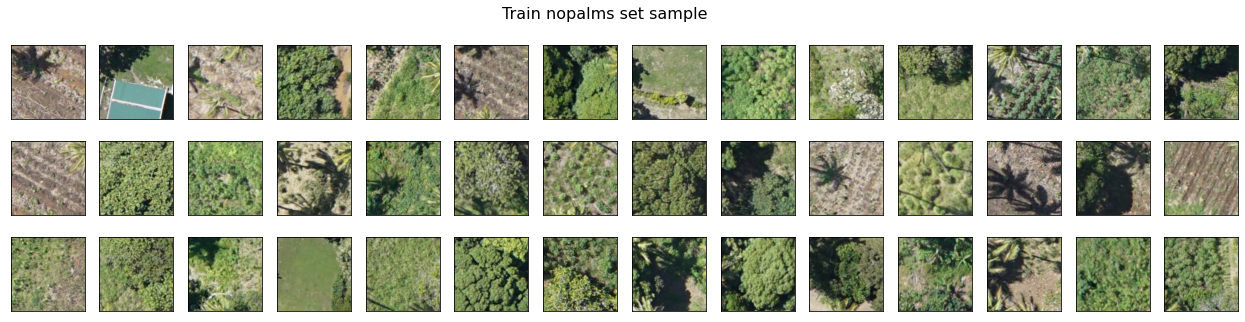

In [19]:
folder = saving_location
imgs = train_list_nopalms
print(f'The number of files in this directory is {len(imgs)}.')

cols = 14

fig, axs = plt.subplots(3, cols, figsize = (22,5))
fig.suptitle('Train nopalms set sample', fontsize=16, color = 'black')
for i in range(cols):
    img_path1 = os.path.join(folder, random.choice(imgs) + '.png')
    img_path2 = os.path.join(folder, random.choice(imgs) + '.png')
    img_path3 = os.path.join(folder, random.choice(imgs) + '.png')
    img1 = Image.open(img_path1)
    img2 = Image.open(img_path2)
    img3 = Image.open(img_path3)
    axs[0,i].imshow(img1)
    axs[1,i].imshow(img2)
    axs[2,i].imshow(img3)

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.show()

In [20]:
train_array_csv = np.array(train_csv)

np.savetxt(f"../tables/train_rotation.csv", train_array_csv, delimiter=',', fmt='%d')

## Data rotation and cropping

In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(csv_file, header=None)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels) 

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, str(self.img_labels.iloc[idx, 0]) + ".png")
        image = Image.open(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

In [4]:
transform = transforms.Compose([transforms.ToTensor()])

In [11]:
batch_size = 8

trainset = CustomImageDataset("../tables/train_rotation.csv", 
                              "../data/train_rotation", 
                              transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)
  
classes = ('no palm', 'palm')

In [12]:
transform_random_rotation = transforms.Compose([transforms.RandomRotation(360),
                                               transforms.CenterCrop(90)]) 

transform_center_crop = transforms.Compose([transforms.CenterCrop(90)])

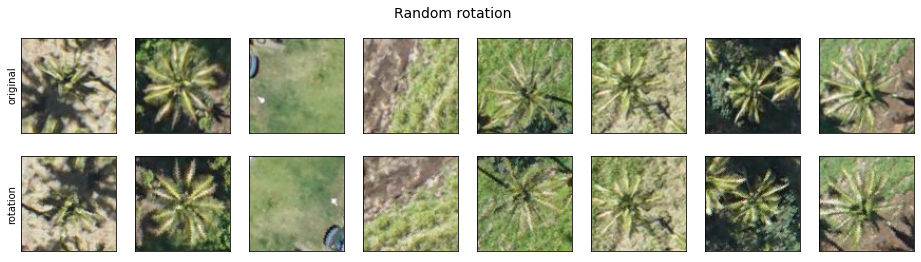

In [13]:
fig, axs = plt.subplots(2, batch_size, figsize = (16,4))
train_features, train_labels = next(iter(trainloader))

for i in range(batch_size):
    img = train_features[i].squeeze()
    img_transformed = transform_random_rotation(img)
    img_center_crop = transform_center_crop(img)
    axs[0,i].imshow(np.transpose(img_center_crop, (1,2,0)))
    axs[1,i].imshow(np.transpose(img_transformed, (1,2,0)))

axs[0,0].set_ylabel('original', color = 'black')
axs[1,0].set_ylabel('rotation', color = 'black')
fig.suptitle('Random rotation', fontsize=14)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.show()

In [14]:
print('End of notebook!')

End of notebook!
